# Comparing methods for strain estimates on seasonal scale - along with lag
Started Aug 5

The goal of this notebook is to try 4 different ways of obtaining daily strain rate estimates from all of our profile data. These methods are as follows:
1. Stacking all the profiles into a daily profile, and calculating the displacements between consecutive days
2. Selecting one profile each day, and calculating displacements between those
3. Use the "leapfrog" window and calculate displacements between bursts 1 day apart, and taking an average for each day (an extension of the above method)
4. Calculate displacements between consecutive bursts, and sum up the total displacements over a day.

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    17:48:28 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    17:48:28 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    17:48:28 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# helper functions
def drop_profile_range(profiles,shift_value): # do 50 m everywhere to avoid surface effects
    profiles_adjust = profiles.where(profiles.profile_range > shift_value, drop = True)
    return profiles_adjust

# generic function for determining displacements
def displacements(b1,b2, win_cor):
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,win_cor,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')
    return dz_new

# generic function for vertical velocities and strain
def vv_strain(dz,noise_floor, bin_adjust=1):
    vv = dz.range_diff / dz.time_diff * 31536000
    vv_adjust = vv - vv.isel(profile_range = range(0,bin_adjust)).mean(dim='profile_range')
    vv_err = dz.err / dz.time_diff * 31536000
    vv_mean_err = (vv_err.isel(profile_range = range(0,bin_adjust))**2).sum(dim='profile_range')/bin_adjust
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err)

    fit=vv_adjust.where(vv_adjust.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv_adjust.where(vv.profile_range <=noise_floor)-vv.where(vv_adjust.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv_adjust.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv_adjust-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv_adjust.profile_range)**2).sum()/len(vv_adjust.profile_range))
    ds = vv_adjust.to_dataset(name='vv')
    ds['err'] = vv_adjust_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

# method zero: no coarsening
def no_coarsen_vv(ds, win_cor, noise_floor, bin_adjust):
    b1 = ds.isel(time=range(0,len(ds)-1))
    b2 = ds.isel(time=range(1,len(ds)))
    dz = displacements(b1,b2, win_cor)
    ds = vv_strain(dz,noise_floor,bin_adjust)
    return ds

# method 1: stack profiles and then calculate vv:
def profile_stack_vv(ds,stack_count,win_cor,noise_floor,bin_adjust):
    ds_stacked = ds.coarsen(time = stack_count,boundary='pad').mean()
    b1 = ds_stacked.isel(time=range(0,len(ds_stacked)-1))
    b2 = ds_stacked.isel(time=range(1,len(ds_stacked)))
    dz = displacements(b1,b2, win_cor)
    ds = vv_strain(dz,noise_floor,bin_adjust)
    return ds

# method 2: select one profile each day and then calculate vv:
def profile_coarsen_vv(ds,sample_count,win_cor,noise_floor,bin_adjust):
    ds_coarsened = ds.isel(time=slice(None, None, sample_count))
    b1 = ds_coarsened.isel(time=range(0,len(ds_coarsened)-1))
    b2 = ds_coarsened.isel(time=range(1,len(ds_coarsened)))
    dz = displacements(b1,b2, win_cor)
    ds = vv_strain(dz,noise_floor,bin_adjust)
    return ds

# method 3: Leapfrog over a lag and take average
def leapfrog_mean_vv(ds,lag,win_cor,noise_floor,bin_adjust):
    def err_from_mean(err,lag):
        new_err = np.sqrt((err**2).coarsen(time = lag,boundary='pad').sum()/lag)
        return new_err
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz = displacements(b1,b2, win_cor)
    ds_raw = vv_strain(dz,noise_floor,bin_adjust)

    ds = ds_raw.coarsen(time = lag,boundary='pad').mean()
    ds['err'] = err_from_mean(ds_raw.err,lag)
    ds['slope_err'] = err_from_mean(ds_raw.slope_err,lag)
    ds['int_err'] = err_from_mean(ds_raw.int_err,lag)
    return ds

# method 4: Get fine displacements, and then sum those up 
def sum_displacements_vv(ds,lag,win_cor,noise_floor,bin_adjust):
    b1 = ds.isel(time=range(0,len(ds)-1))
    b2 = ds.isel(time=range(1,len(ds)))
    dz = displacements(b1,b2, win_cor)
    vv = dz.range_diff.coarsen(time=lag,boundary='pad').sum()/dz.time_diff.coarsen(time=lag,boundary='pad').sum()*31536000
    vv_err = np.sqrt(((dz.err)**2).coarsen(time=lag,boundary='pad').sum())/dz.time_diff.coarsen(time=lag,boundary='pad').sum()*31536000

    vv_adjust = vv - vv.isel(profile_range = range(0,bin_adjust)).mean(dim='profile_range')
    vv_mean_err = (vv_err.isel(profile_range = range(0,bin_adjust))**2).sum(dim='profile_range')/bin_adjust
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err)

    fit=vv_adjust.where(vv_adjust.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv_adjust.where(vv.profile_range <=noise_floor)-vv.where(vv_adjust.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv_adjust.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv_adjust-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv_adjust.profile_range)**2).sum()/len(vv_adjust.profile_range))
    ds = vv_adjust.to_dataset(name='vv')
    ds['err'] = vv_adjust_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

In [3]:
# Test with A11 summer and winter
with open('../streamlined_methods/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../streamlined_methods/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [4]:
test = no_coarsen_vv(winter, 50, 500, 2)
test1 = profile_stack_vv(winter,96,50,500,2)
test2 = profile_coarsen_vv(winter,96,50,500,2)
test3 = leapfrog_mean_vv(winter,96,50,500,2)
test4 = sum_displacements_vv(winter,96,50,500,2)

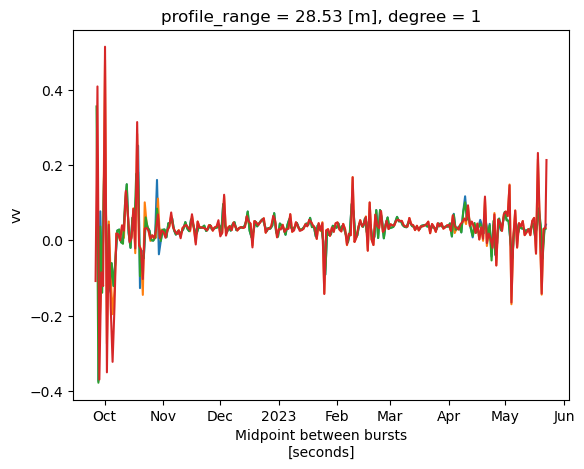

In [9]:
dropped = drop_profile_range(winter,20)
test = no_coarsen_vv(dropped, 80, 500, 2)
test1 = profile_stack_vv(dropped, 96,80,500,2)
test2 = profile_coarsen_vv(dropped, 96,80,500,2)
test3 = leapfrog_mean_vv(dropped, 96,80,500,2)
test4 = sum_displacements_vv(dropped, 96,80,500,2)
#test.vv.isel(profile_range=0).plot()
test1.vv.isel(profile_range=0).plot()
test2.vv.isel(profile_range=0).plot()
test3.vv.isel(profile_range=0).plot()
test4.vv.isel(profile_range=0).plot()

Method 1: mean vv err: 0.117220, mean fit err: 0.000133 
 mean strain: -0.002998 +/- 0.000521.
Method 2: mean vv err: 0.137052, mean fit err: 0.000234 
 mean strain: -0.003019 +/- 0.000508.
Method 3: mean vv err: 0.086749, mean fit err: 0.000232 
 mean strain: -0.003004 +/- 0.000475.
Method 4: mean vv err: 3.736033, mean fit err: 0.000283 
 mean strain: -0.002973 +/- 0.000914.


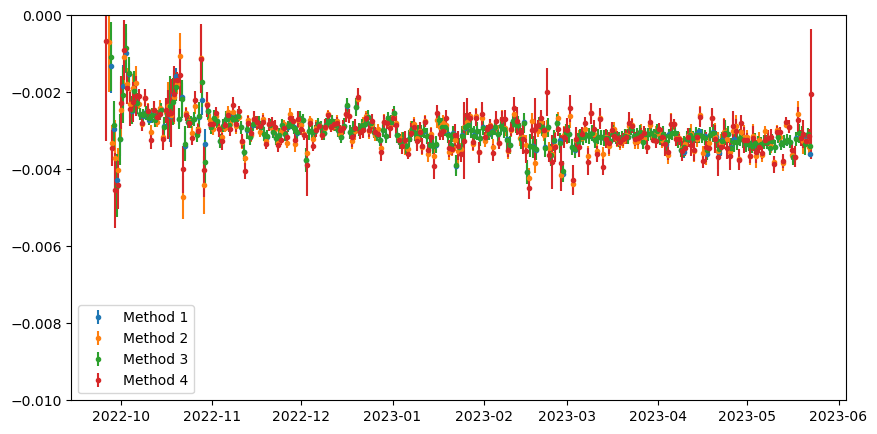

In [10]:
def strain_plot(ds,ax,label):
    ax.errorbar(ds.time.values,ds.slope,ds.slope_err,label=label,linestyle='None',marker='.')
    print(f'{label}: mean vv err: {np.nanmean(ds.err):.6f}, mean fit err: {np.nanmean(ds.slope_err):.6f} \n mean strain: {np.nanmean(ds.slope):.6f} +/- {np.nanstd(ds.slope):.6f}.')
#strain_plot(test,label='Between consecutive bursts')

fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,0])
plt.legend()


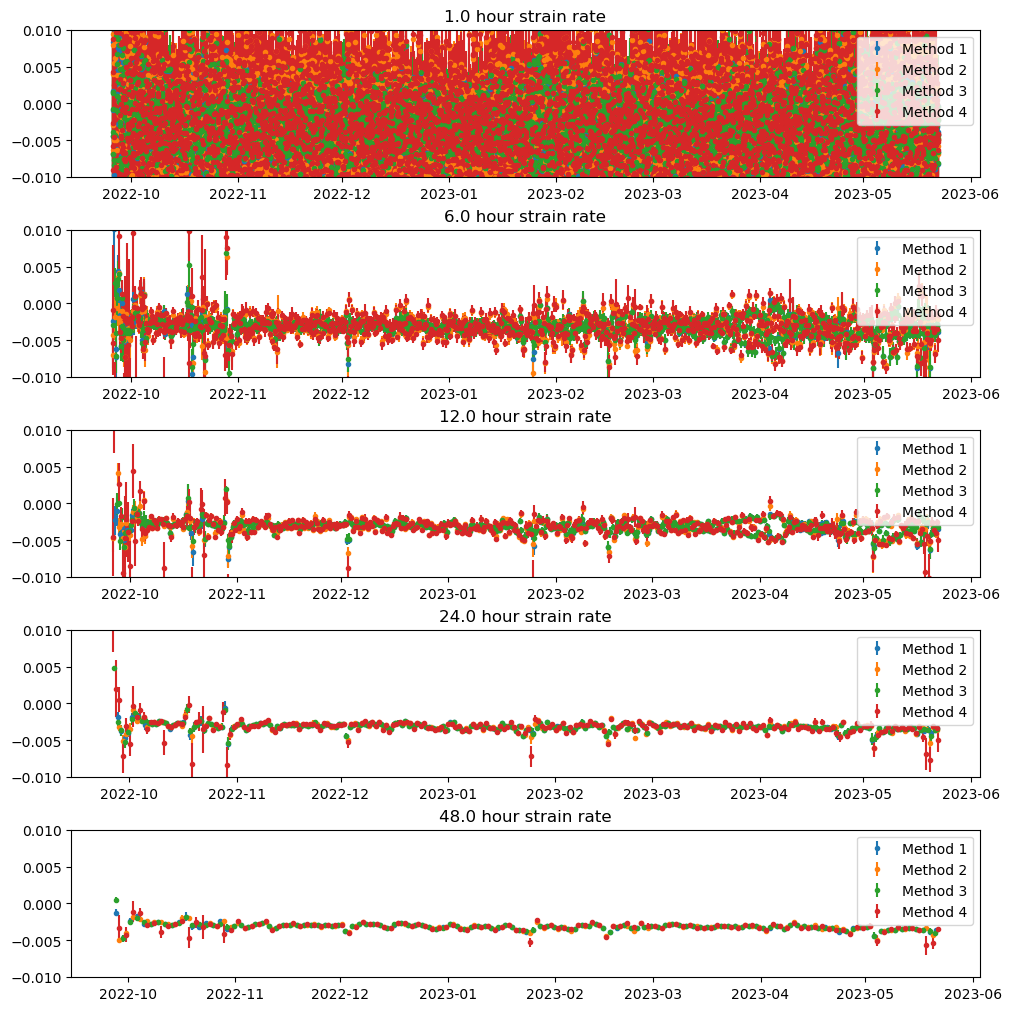

In [15]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(winter,window,50,500,2)
    test2 = profile_coarsen_vv(winter,window,50,500,2)
    test3 = leapfrog_mean_vv(winter,window,50,500,2)
    test4 = sum_displacements_vv(winter,window,50,500,2)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

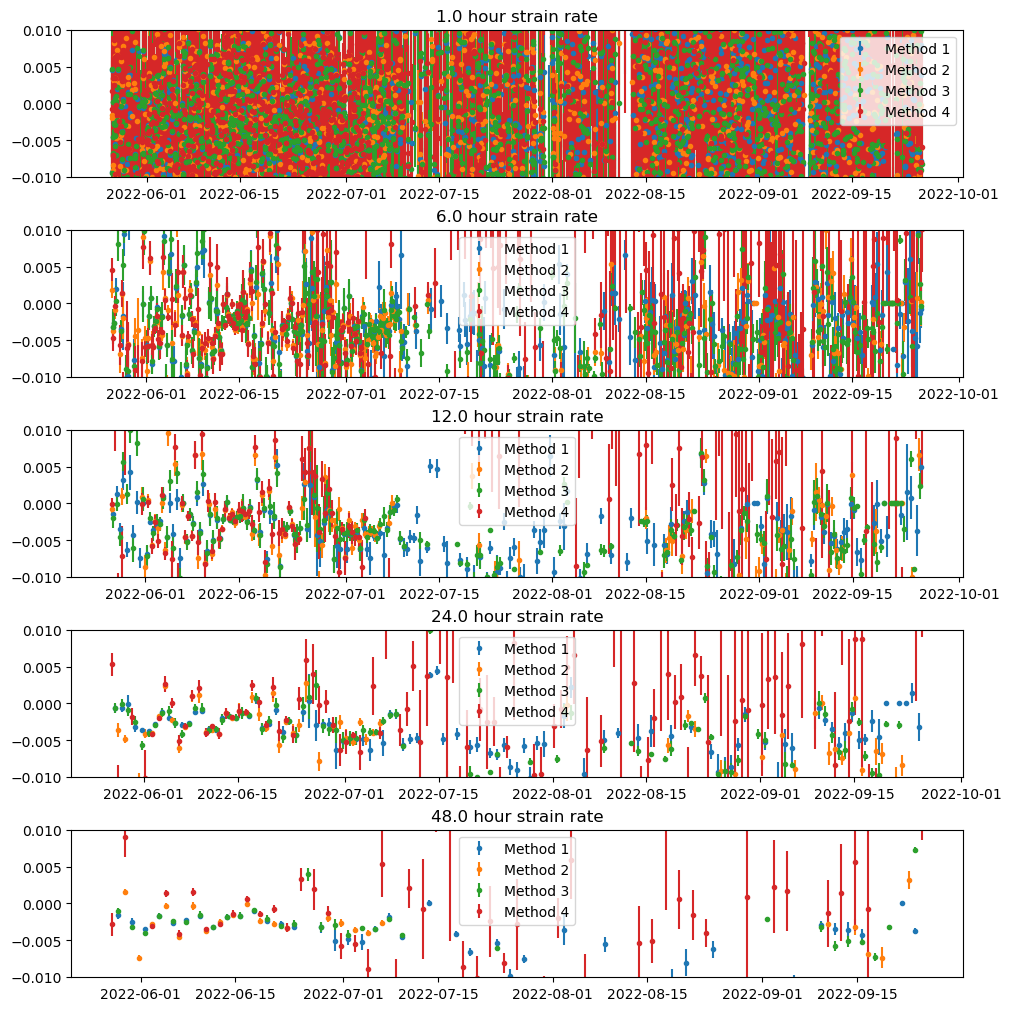

In [16]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(s22,window,50,500,2)
    test2 = profile_coarsen_vv(s22,window,50,500,2)
    test3 = leapfrog_mean_vv(s22,window,50,500,2)
    test4 = sum_displacements_vv(s22,window,50,500,2)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

In [17]:
# A13
with open('../chirp_processing/A13_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A13_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

with open('../chirp_processing/A13_23S.pickle', 'rb') as handle:
    s23 = pickle.load(handle)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

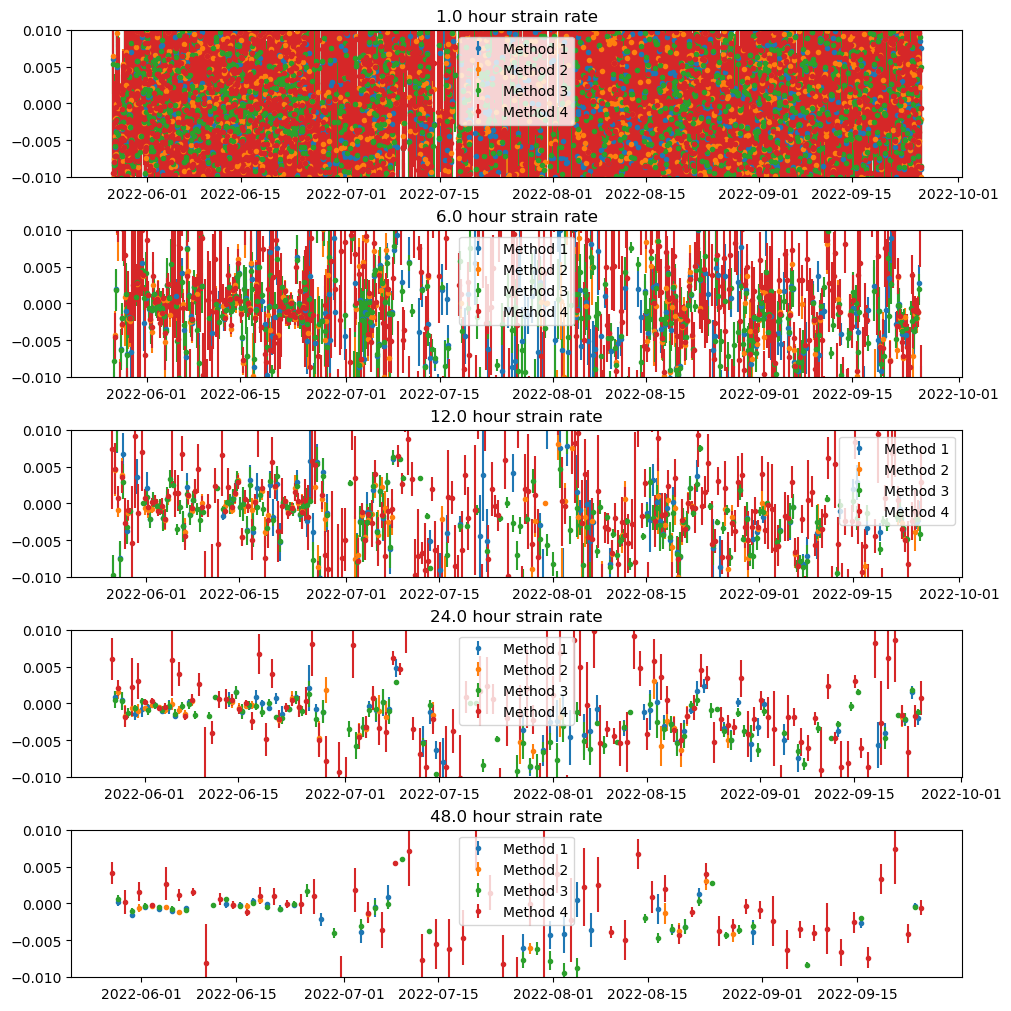

In [18]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(s22,window,24,500,1)
    test2 = profile_coarsen_vv(s22,window,24,500,1)
    test3 = leapfrog_mean_vv(s22,window,24,500,1)
    test4 = sum_displacements_vv(s22,window,24,500,1)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

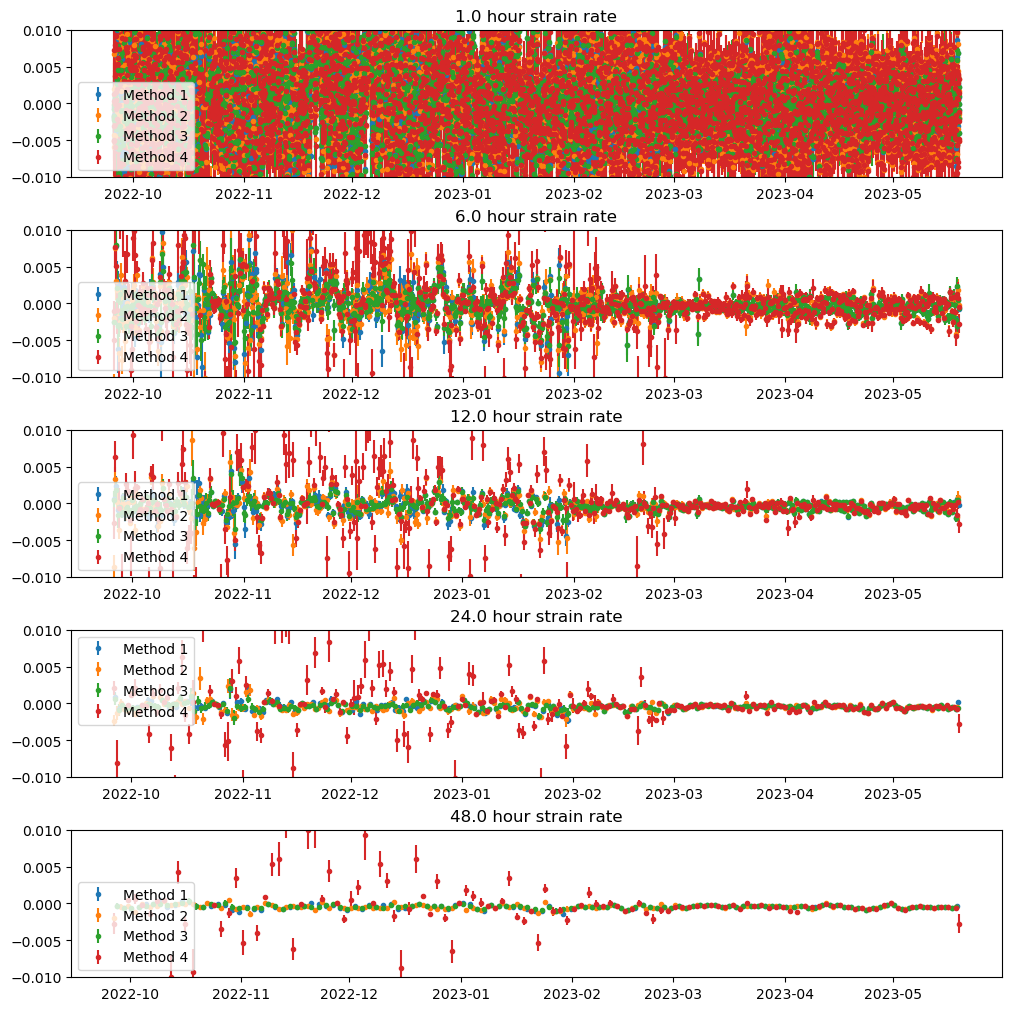

In [19]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(winter,window,24,500,1)
    test2 = profile_coarsen_vv(winter,window,24,500,1)
    test3 = leapfrog_mean_vv(winter,window,24,500,1)
    test4 = sum_displacements_vv(winter,window,24,500,1)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

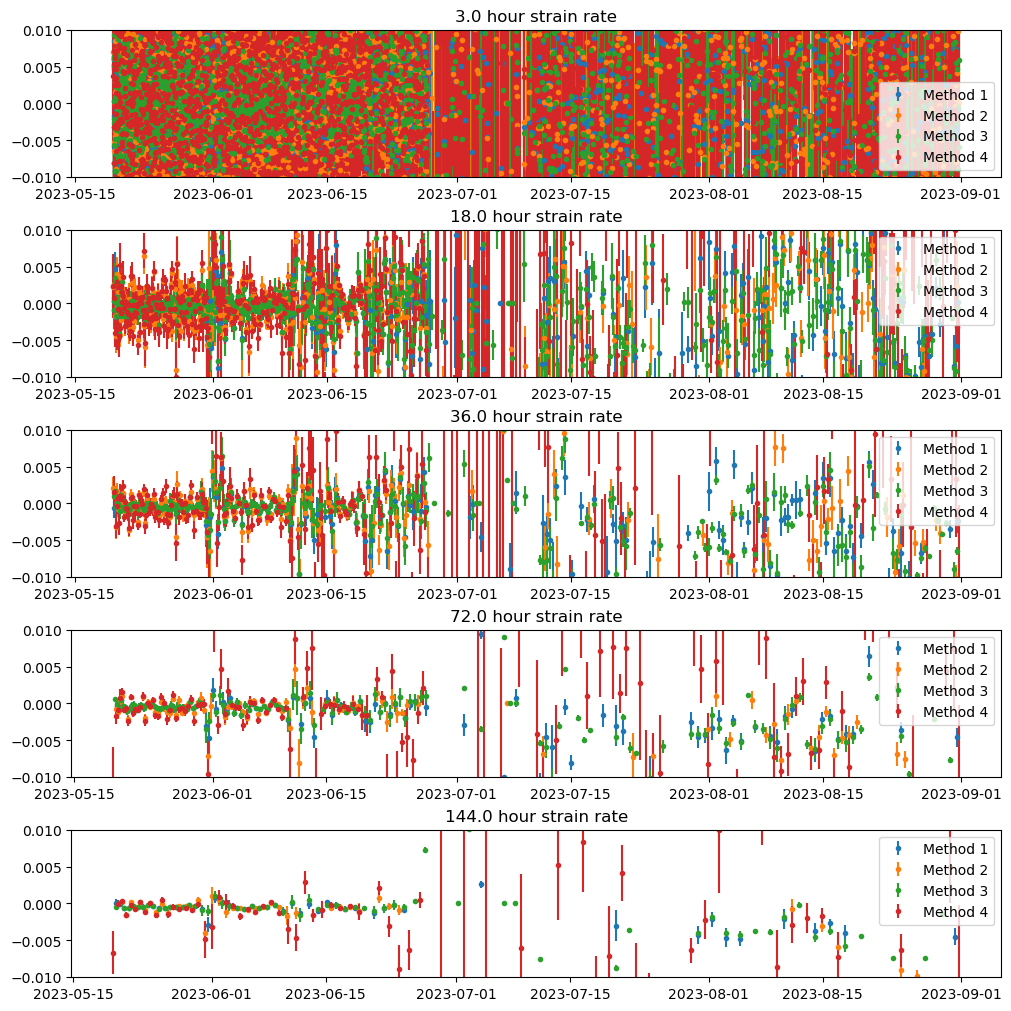

In [22]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]*3
    test1 = profile_stack_vv(s23,window,24,500,1)
    test2 = profile_coarsen_vv(s23,window,24,500,1)
    test3 = leapfrog_mean_vv(s23,window,24,500,1)
    test4 = sum_displacements_vv(s23,window,24,500,1)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

In [23]:
# A14
with open('../chirp_processing/A14_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A14_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

with open('../chirp_processing/A14_23S.pickle', 'rb') as handle:
    s23 = pickle.load(handle)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

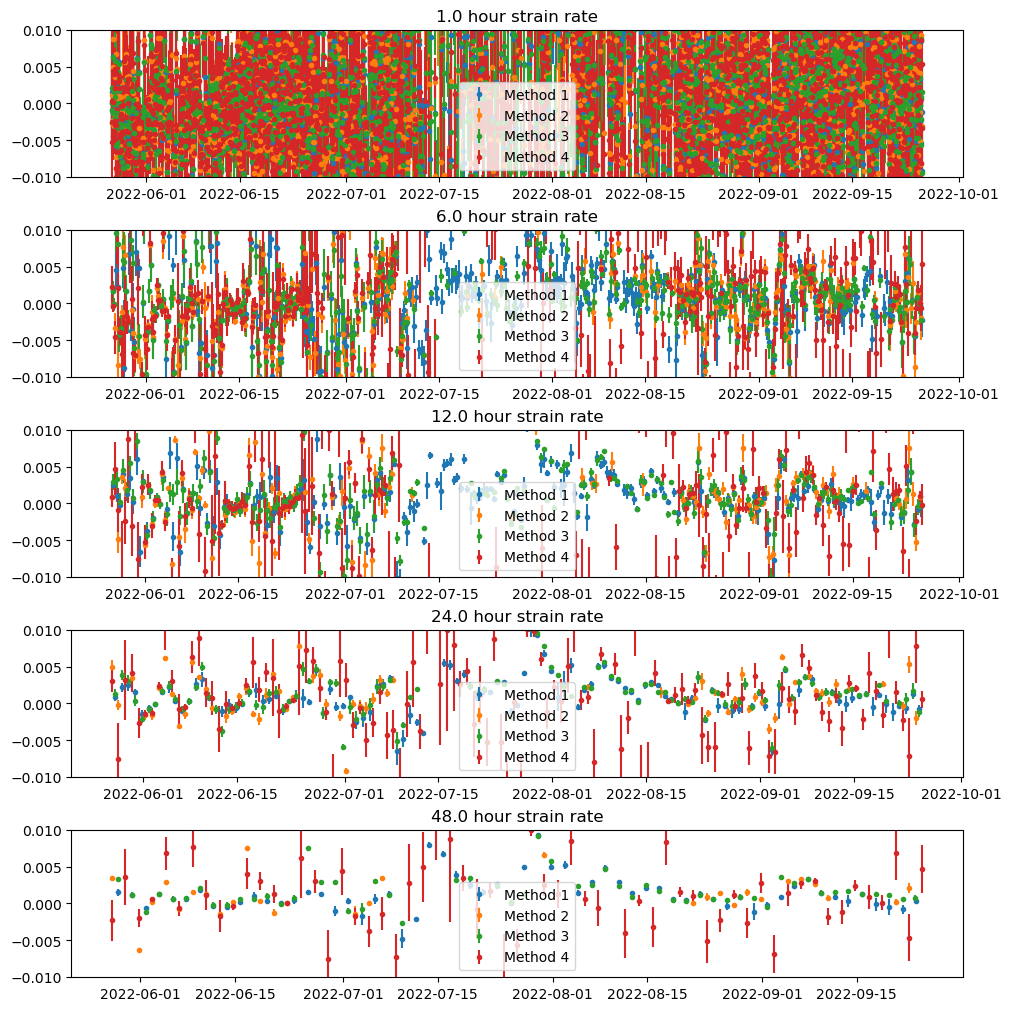

In [24]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(s22,window,80,500,2)
    test2 = profile_coarsen_vv(s22,window,80,500,2)
    test3 = leapfrog_mean_vv(s22,window,80,500,2)
    test4 = sum_displacements_vv(s22,window,80,500,2)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

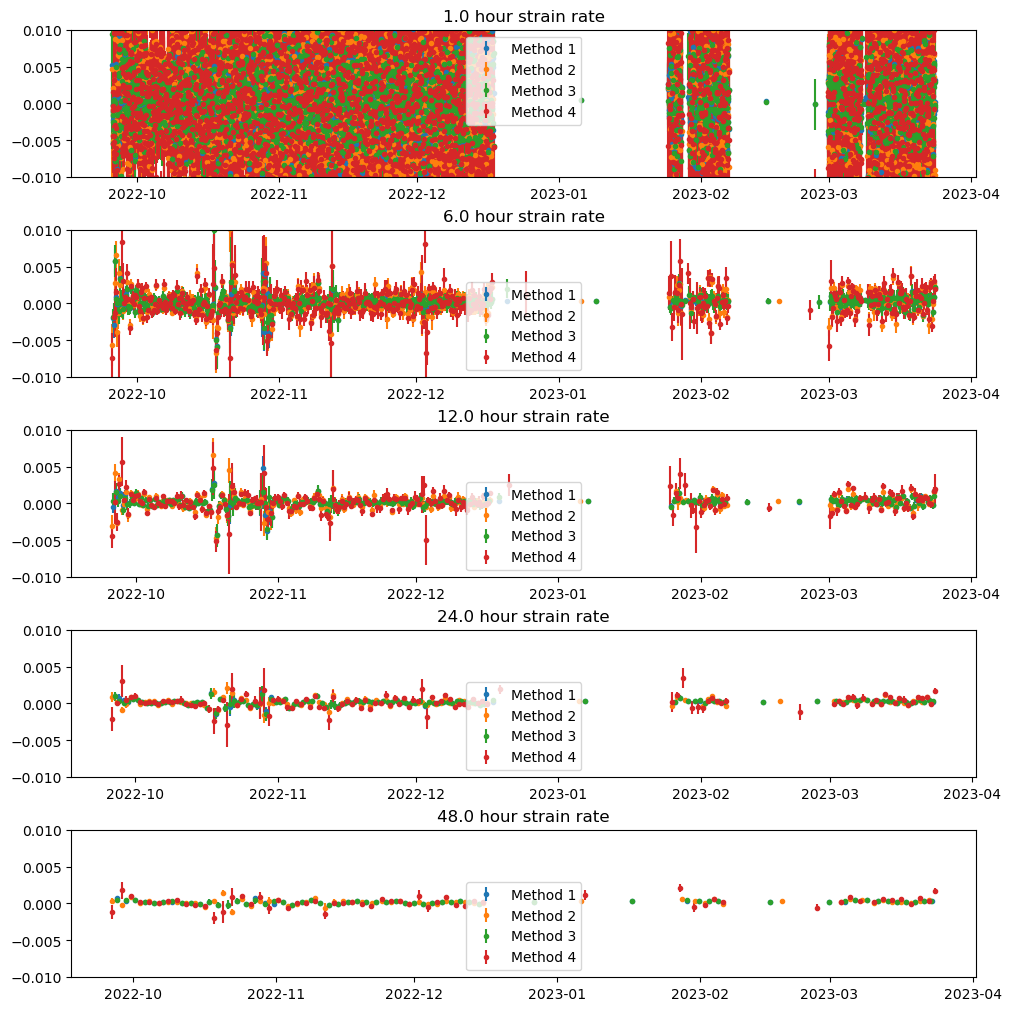

In [25]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(winter,window,80,500,2)
    test2 = profile_coarsen_vv(winter,window,80,500,2)
    test3 = leapfrog_mean_vv(winter,window,80,500,2)
    test4 = sum_displacements_vv(winter,window,80,500,2)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

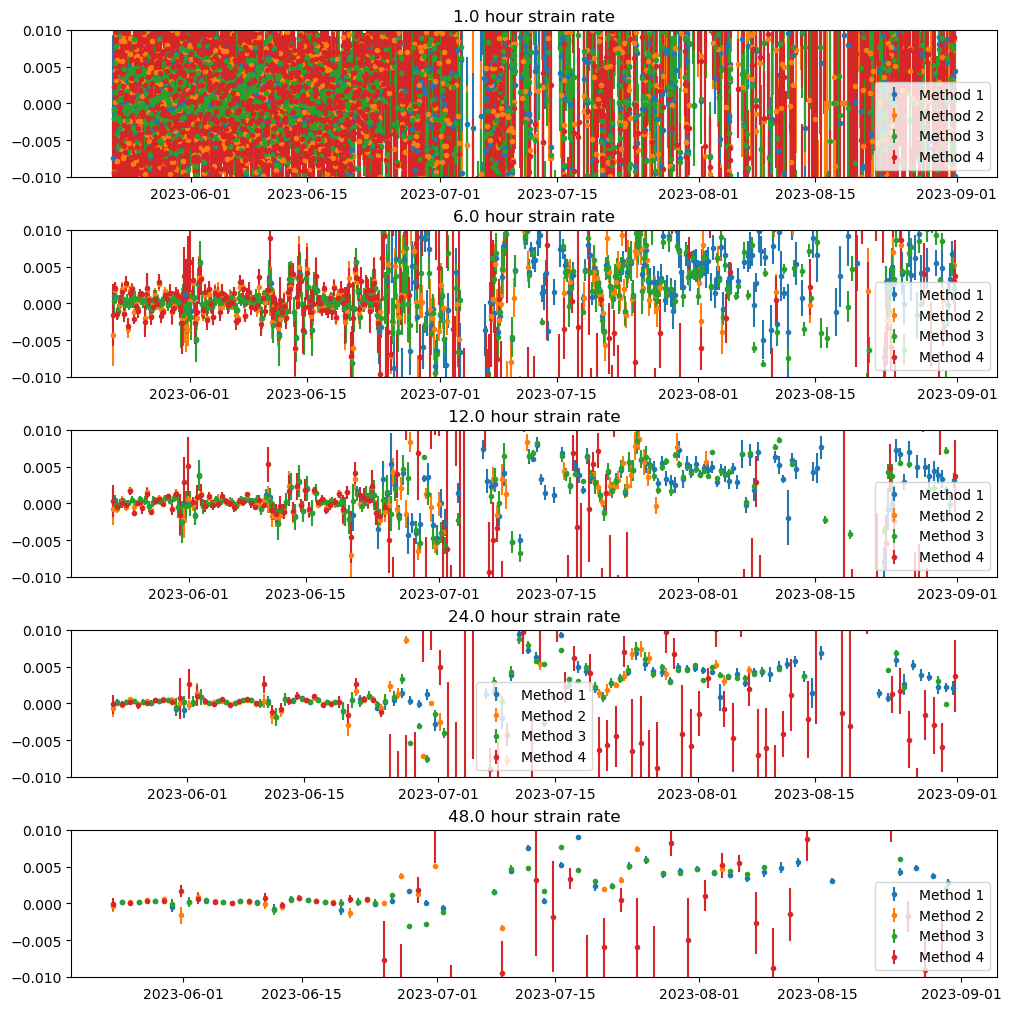

In [26]:
# try different time windows
fig, axs = plt.subplots(figsize=(10,10),nrows = 5,layout = 'constrained')
time_windows = [4, 24, 48, 96, 192]
for i in range(5):
    window = time_windows[i]
    test1 = profile_stack_vv(s23,window,80,500,2)
    test2 = profile_coarsen_vv(s23,window,80,500,2)
    test3 = leapfrog_mean_vv(s23,window,80,500,2)
    test4 = sum_displacements_vv(s23,window,80,500,2)
    strain_plot(test1,axs[i],label='Method 1')
    strain_plot(test2,axs[i],label='Method 2')
    strain_plot(test3,axs[i],label='Method 3')
    strain_plot(test4,axs[i],label='Method 4')
    axs[i].set_ylim([-1e-2,1e-2])
    axs[i].legend()
    axs[i].set_title(f'{window/4} hour strain rate')
        

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.294533, mean fit err: 0.000715 
 mean strain: -0.002882 +/- 0.002984.
Method 2: mean vv err: 0.325025, mean fit err: 0.000729 
 mean strain: -0.002869 +/- 0.004240.
Method 3: mean vv err: 0.124465, mean fit err: 0.000751 
 mean strain: -0.003453 +/- 0.003793.
Method 4: mean vv err: 5.834629, mean fit err: 0.004908 
 mean strain: -0.000528 +/- 0.027668.


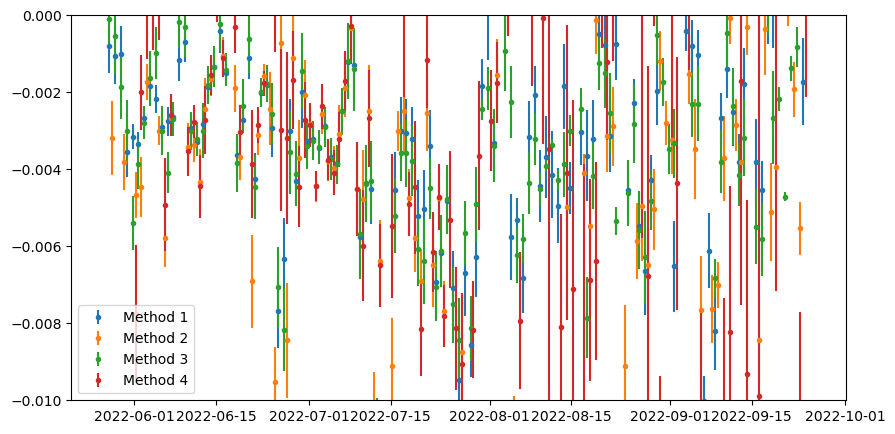

In [11]:
# Assuming daily time windows
# Test with A11 summer and winter
with open('../streamlined_methods/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../streamlined_methods/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

dropped = drop_profile_range(s22,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,0])
plt.legend()

Method 1: mean vv err: 0.147165, mean fit err: 0.000130 
 mean strain: -0.002982 +/- 0.000527.
Method 2: mean vv err: 0.171308, mean fit err: 0.000232 
 mean strain: -0.003001 +/- 0.000551.
Method 3: mean vv err: 0.111582, mean fit err: 0.000235 
 mean strain: -0.002987 +/- 0.000489.
Method 4: mean vv err: 5.473766, mean fit err: 0.000287 
 mean strain: -0.002954 +/- 0.000653.


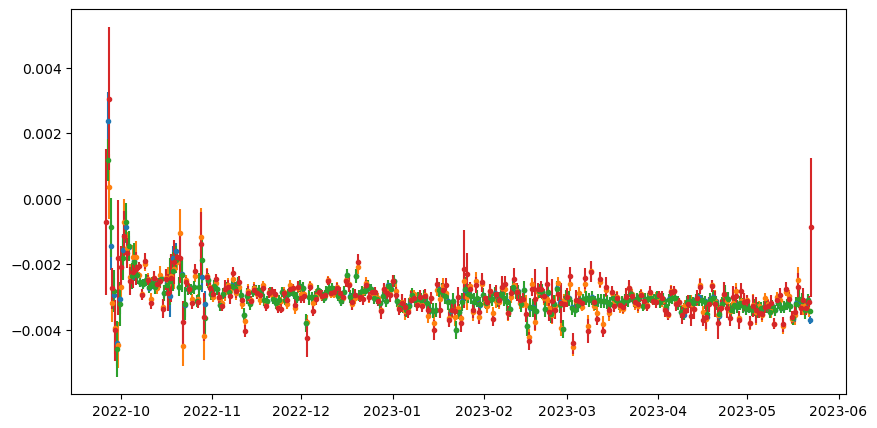

In [12]:
dropped = drop_profile_range(winter,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')

In [13]:
# A13
with open('../chirp_processing/A13_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A13_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

with open('../chirp_processing/A13_23S.pickle', 'rb') as handle:
    s23 = pickle.load(handle)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.374490, mean fit err: 0.000801 
 mean strain: -0.000445 +/- 0.003006.
Method 2: mean vv err: 0.437936, mean fit err: 0.000926 
 mean strain: -0.001107 +/- 0.007467.
Method 3: mean vv err: 0.206561, mean fit err: 0.001035 
 mean strain: -0.000448 +/- 0.002457.
Method 4: mean vv err: 9.350400, mean fit err: 0.002628 
 mean strain: 0.000586 +/- 0.006576.


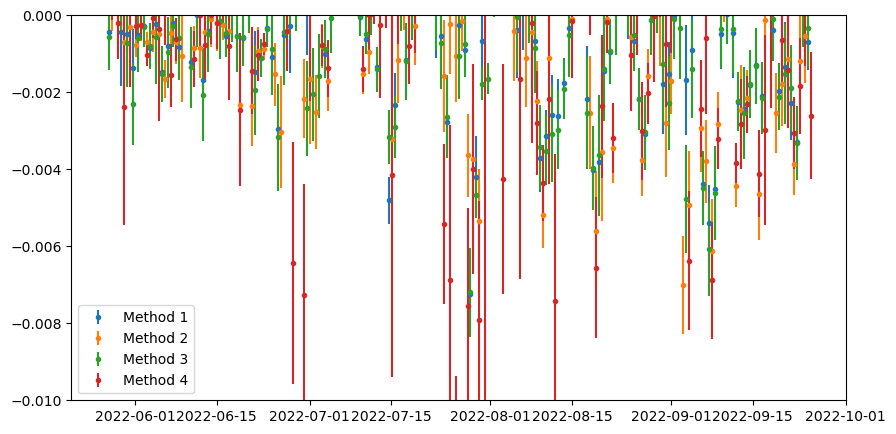

In [14]:
dropped = drop_profile_range(s22,20)
test = no_coarsen_vv(dropped, 20, 500, 2)
test1 = profile_stack_vv(dropped, 96,20,500,2)
test2 = profile_coarsen_vv(dropped, 96,20,500,2)
test3 = leapfrog_mean_vv(dropped, 96,20,500,2)
test4 = sum_displacements_vv(dropped, 96,20,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,0])
plt.legend()

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.191491, mean fit err: 0.000141 
 mean strain: -0.000366 +/- 0.000326.
Method 2: mean vv err: 0.198278, mean fit err: 0.000239 
 mean strain: -0.000348 +/- 0.000497.
Method 3: mean vv err: 0.112470, mean fit err: 0.000262 
 mean strain: -0.000371 +/- 0.000293.
Method 4: mean vv err: 4.868377, mean fit err: 0.001204 
 mean strain: 0.000382 +/- 0.004346.


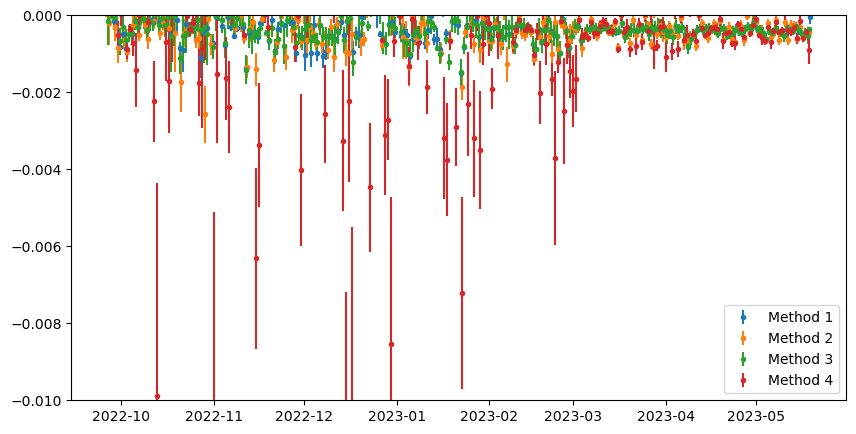

In [15]:
dropped = drop_profile_range(winter,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,0])
plt.legend()

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.359361, mean fit err: 0.000627 
 mean strain: -0.000789 +/- 0.002936.
Method 2: mean vv err: 0.398500, mean fit err: 0.000748 
 mean strain: -0.000801 +/- 0.004337.
Method 3: mean vv err: 0.184689, mean fit err: 0.000792 
 mean strain: -0.000979 +/- 0.005355.
Method 4: mean vv err: 16.090323, mean fit err: 0.009816 
 mean strain: 0.008919 +/- 0.071005.


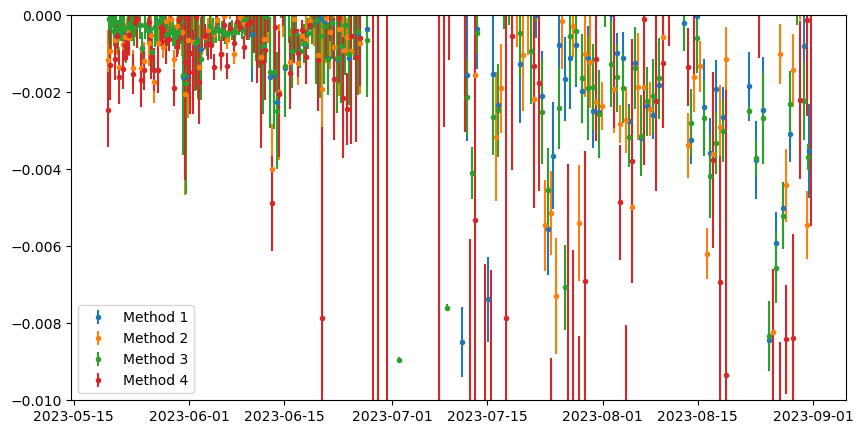

In [16]:
dropped = drop_profile_range(s23,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96*3,50,500,2)
test2 = profile_coarsen_vv(dropped, 96*3,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96*3,50,500,2)
test4 = sum_displacements_vv(dropped, 96*3,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,0])
plt.legend()

In [17]:
# A14
with open('../chirp_processing/A14_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A14_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

with open('../chirp_processing/A14_23S.pickle', 'rb') as handle:
    s23 = pickle.load(handle)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.262879, mean fit err: 0.000468 
 mean strain: 0.001632 +/- 0.002659.
Method 2: mean vv err: 0.308621, mean fit err: 0.000621 
 mean strain: 0.001754 +/- 0.003550.
Method 3: mean vv err: 0.130108, mean fit err: 0.000605 
 mean strain: 0.001698 +/- 0.002691.
Method 4: mean vv err: 4.766736, mean fit err: 0.001734 
 mean strain: 0.003211 +/- 0.005158.


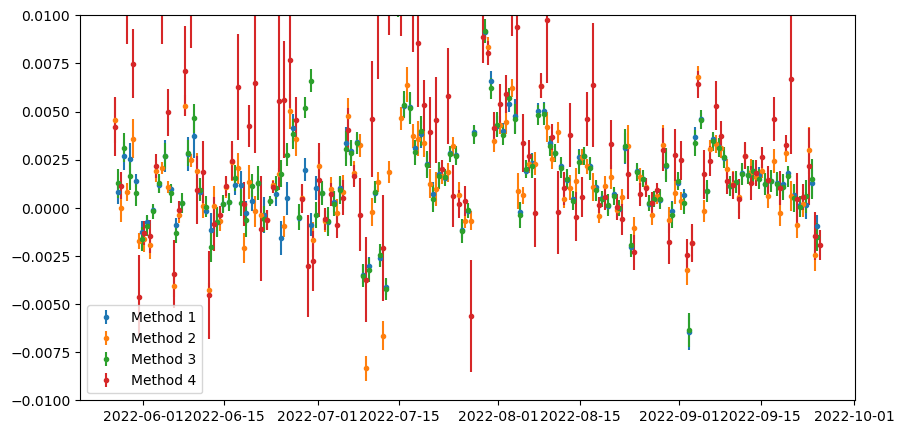

In [19]:
dropped = drop_profile_range(s22,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,1e-2])
plt.legend()

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.134333, mean fit err: 0.000106 
 mean strain: 0.000204 +/- 0.000401.
Method 2: mean vv err: 0.163778, mean fit err: 0.000277 
 mean strain: 0.000194 +/- 0.000636.
Method 3: mean vv err: 0.077728, mean fit err: 0.000289 
 mean strain: 0.000213 +/- 0.000401.
Method 4: mean vv err: 4.681872, mean fit err: 0.000406 
 mean strain: 0.000111 +/- 0.000864.


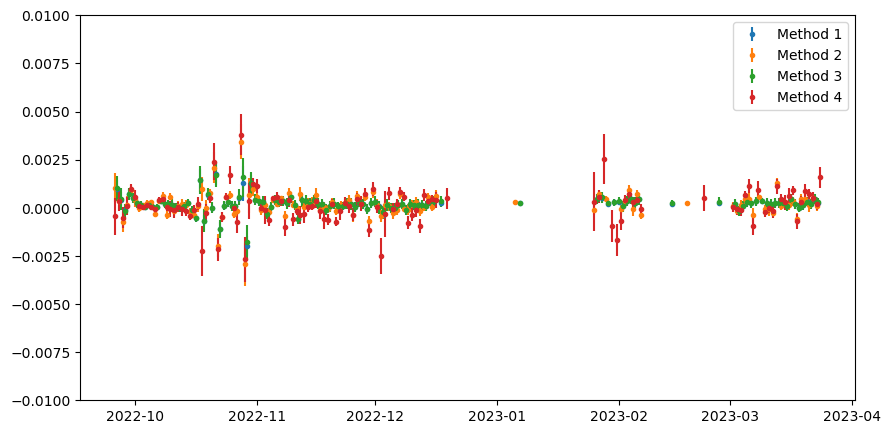

In [20]:
dropped = drop_profile_range(winter,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,1e-2])
plt.legend()

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Method 1: mean vv err: 0.276825, mean fit err: 0.000524 
 mean strain: 0.002356 +/- 0.002464.
Method 2: mean vv err: 0.283485, mean fit err: 0.000483 
 mean strain: 0.001995 +/- 0.003993.
Method 3: mean vv err: 0.101483, mean fit err: 0.000537 
 mean strain: 0.001870 +/- 0.003354.
Method 4: mean vv err: 5.751898, mean fit err: 0.004184 
 mean strain: 0.005080 +/- 0.014649.


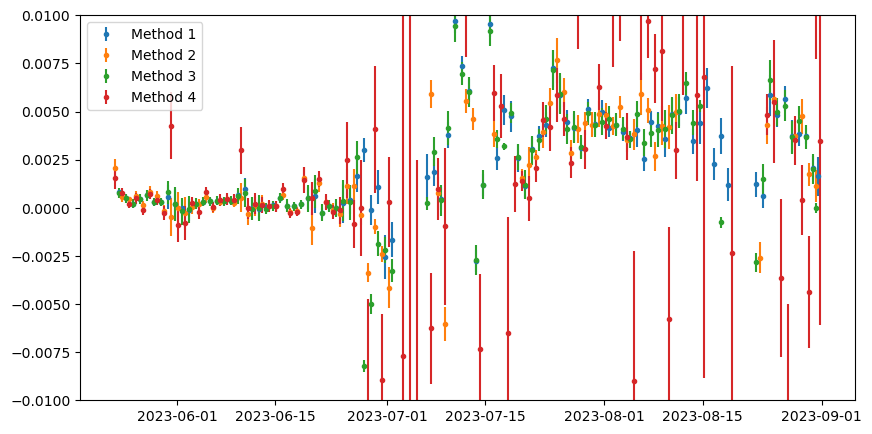

In [21]:
dropped = drop_profile_range(s23,20)
test = no_coarsen_vv(dropped, 50, 500, 2)
test1 = profile_stack_vv(dropped, 96,50,500,2)
test2 = profile_coarsen_vv(dropped, 96,50,500,2)
test3 = leapfrog_mean_vv(dropped, 96,50,500,2)
test4 = sum_displacements_vv(dropped, 96,50,500,2)
fig, ax = plt.subplots(figsize = (10,5))
strain_plot(test1,ax,label='Method 1')
strain_plot(test2,ax,label='Method 2')
strain_plot(test3,ax,label='Method 3')
strain_plot(test4,ax,label='Method 4')


plt.ylim([-1e-2,1e-2])
plt.legend()